In [ ]:
from nbdev import *
# default_exp lightcurve
#%nbdev_default_export lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc
!date

Tue May 18 16:25:35 PDT 2021


# Light Curve Generation
> Generate light curves from cells

A "light curve" is a table with columns

- `t` -- time in MJD 
- `tw` -- the cell width
- `n`  -- number of photons
- `e`  -- exposure, in $10^6 s\ cm^2$ units
- `fit` -- the fit object, containing info about the flux. This is usually a `PoissonRep` object

It is generated from a set of cells



In [ ]:
# export
import numpy as np
import pylab as plt
import pandas as pd
from wtlike.config import *
from wtlike.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable)
from wtlike.cell_data import *

In [ ]:
# export
class _LightCurve(object):
    """ Apply likelihood fits to a set of cells
    
    parameters:
       - cells : a table with index t, columns  tw, n, e, w, S, B
       - exp_min : minimum fractional exposure allowed
       - rep_name : represention to use 

    Generates a DataFrame with columns n, ep, fit
        
    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config, 
                cells, 
                source_name, 
                rep_name: 'likelihood rep name'='',
    
                ):
        """Apply fits to the likelihoods for a set of cells
        
 
        """

        self.source_name = source_name
        self.config=config
 
        # select the set of cells
        
        self.cells = cells 
        
        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
         # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')
        
        # making output with reduced columns 
        self.ll_fits = cells['t tw n e'.split()].copy()
        try:
            self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
        except Exception as e:
            print(f'Failed a fit: \n{e}', file=sys.sterr)
            raise
            

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'
    
    def full_likelihood():
        return LogLike(concatenate_cells(self.cells))

    @property
    def dataframe(self):
        return self.ll_fits
#     def plot(self, **kwargs):
#         flux_plot(self.config, self, **kwargs)

In [ ]:
# export
def fit_cells(config, 
            input_cells, 
            repcl = PoissonRep,

            ):
    """Apply fits to the likelihoods for a set of cells
    return light-curve dataframe

    """

    # select the set of cells
    cells = input_cells.copy()

    # generate a list of LogLike objects for each
    cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
    if config.verbose>0:
        print(f'LightCurve: Loaded {len(cells)} / {len(input_cells)} cells for fitting')
  
    # making output with reduced columns 
    ll_fits = cells['t tw n e'.split()].copy()
    ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
    
    return ll_fits

In [ ]:
# export  

def get_LightCurve(config,  source, cell_query='e>1e-6',  key=''):
    """Returns a lightcurve table for the source
    
    - `source` -- a PointSource object
    - `cell query` -- query to apply to cell selection
    - `bin_edges` -- optional to select other than default described in config
    - `key` -- optional cache key. Set to None to disable cache use
    
    """
    def doit():
        cell_data = CellData(config,  source)
        cells = cell_data.df.query(cell_query)
        assert len(cells)>0, 'No cells from CellData after query'
        lc = _LightCurve(config, cells, source).dataframe
        return lc
        
#     if bin_edges is None:
        # use cache only with default bins
    key = f'lightcurve_{source_name}' if key=='' else  key 
    description = f'Light curve with {cell_query} for {source_name}' if config.verbose>0 and key is not None else '' 
    return config.cache(key, doit, description=description)
#     else:
#         return doit()

In [ ]:
# export
def fit_table(lc, expect=1.0):
    """Generate a summary table from a light curve dataframe"""
    fits = lc.fit
    flux = fits.apply(lambda f: f.flux)
    errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), rorebinnedund(f.errors[1]-f.flux ,3) ) )
    sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
    df = lc['t tw n'.split()].copy() # maybe fix warnings?
    df.loc[:,'flux'] = flux.values.round(4)
    df.loc[:, 'errors'] = errors.values
    df.loc[:, 'sigma_dev'] = sigma_dev.values
    df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
    return df

In [ ]:
# export
def flux_plot(cell_fits,
              query='',
              ax=None, fignum=1, figsize=(12,4),
              title=None, 
              step=False, 
              tzero:'time offset'=0,
              flux_factor=1,
              colors=('cornflowerblue','sandybrown', 'blue'), 
              fmt='', ms=None, error_size=2,
              source_name=None,
              ts_bar_min=4,
              zorder=0,
              errorbar_args={},
              **kwargs): 
    """Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`
    
    - cell_fits -- cell fits DataFrame 
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins, else 'o'
    - ms [None] -- for marker size
    - error_size [2] -- apply to error bars
    - colors -- tuple of colors for signal, limit, step
    - step   -- add a "step" plot
    - zorder -- set to different number to order successive calls with same Axis object
    - kwargs -- apply to the `ax` object, like xlim, ylim
    
    returns the Figure instance
    """
    import matplotlib.ticker as ticker
    label = kwargs.pop('label', None)
    step_label = kwargs.pop('step_label', None)
    limit_fmt = kwargs.pop('limit_fmt', None)
    ms = kwargs.pop('ms', None)
    error_size=kwargs.pop('error_size', 2)
    
    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)
    kw=dict(yscale='linear',
            xlabel='MJD'+ f' - {tzero} [{UTC(tzero)[:10]}]' if tzero else 'MJD' ,
            ylabel='Relative flux',)
    kw.update(**kwargs)
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')
    ax.grid(alpha=0.5)
    if kw['yscale']=='log' and flux_factor==1:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda val,pos: { 1.0:'1', 10.0:'10', 100.:'100'}.get(val,'')))

    df = cell_fits.copy() 
    df.loc[:,'ts'] = df.fit.apply(lambda f: f.ts) 
    if query:
        df = df.query(query)
    
    if fmt=='':
        fmt='.' if len(df)>200 else 'o'

    limit = df.ts<ts_bar_min
    bar = df.loc[~limit,:]
    lim = df.loc[limit,:]
    allflux= np.select([~limit, limit], 
                    [df.fit.apply(lambda f: f.flux).values,
                     df.fit.apply(lambda f: f.limit).values],
                   ) * flux_factor
    
    # do the limits first (only for poisson rep)
    if len(lim)>0:
        t = lim.t-tzero
        tw = lim.tw 
        color = colors[2 if step else 1] 

        y = allflux[limit] 
        if limit_fmt is None:
            # try to draw an error bar, hard to determine size
            yerr=0.2*(1 if kw['yscale']=='linear' else y)*flux_factor
            ax.errorbar(x=t, y=y, xerr=tw/2,
                    yerr=yerr,  color=color , 
                    uplims=True, ls='', 
                    ms=ms, lw=error_size, capsize=2*error_size, capthick=0,
                    zorder=zorder, label='95% limit', **errorbar_args)
                   
        else:
            # just a symbol, like 'v'
            ax.errorbar(x=t,xerr=tw/2, y=y, fmt=limit_fmt, color=color,
                       zorder=zorder, label='95% limit', **errorbar_args)
    
    # then the points with error bars
    t = bar.t.values-tzero
    tw = bar.tw.values.astype(float) 
    fluxmeas = allflux[~limit]
    upper = bar.fit.apply(lambda f: f.errors[1]).values * flux_factor
    lower = bar.fit.apply(lambda f: f.errors[0]).values * flux_factor
    error = np.array([upper-fluxmeas, fluxmeas-lower])
#     if label is None:
#         label = f'{bin_size_name(round(tw.mean(),4))} bins' if np.std(tw)<1e-6 else ''
    ax.errorbar(
        x=t, xerr=tw/2, 
                y=fluxmeas, yerr=error, lw=2, fmt=fmt, 
                color=colors[0], 
                label=label, zorder=zorder+1, **errorbar_args)
    
    # finally ovelay the step if requested
    if step:
        t = df.t.values-tzero
        xerr = df.tw.values/2; 
        x = np.append(t-xerr, [t[-1]+xerr[-1]]); 
        y = np.append(allflux, [allflux[-1]])
        ax.step(x, y, 
                color=colors[2], where='post', lw=2, label=step_label,  zorder=zorder+2)
        
    # the legend: if added overplot, make sure it is below
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],loc='upper left', fontsize=10, frameon=False)
    #ax.legend()
    
    if source_name is not None:
        ax.text(0.99, 0.9, source_name, transform=ax.transAxes, ha='right' )
        
    return fig


In [ ]:
show_doc(flux_plot, title_level=3)

<h3 id="flux_plot" class="doc_header"><code>flux_plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>flux_plot</code>(**`cell_fits`**, **`query`**=*`''`*, **`ax`**=*`None`*, **`fignum`**=*`1`*, **`figsize`**=*`(12, 4)`*, **`title`**=*`None`*, **`step`**=*`False`*, **`tzero`**:`time offset`=*`0`*, **`flux_factor`**=*`1`*, **`colors`**=*`('cornflowerblue', 'sandybrown', 'blue')`*, **`fmt`**=*`''`*, **`ms`**=*`None`*, **`error_size`**=*`2`*, **`source_name`**=*`None`*, **`ts_bar_min`**=*`4`*, **`zorder`**=*`0`*, **`errorbar_args`**=*`{}`*, **\*\*`kwargs`**)

Make a plot of flux vs. time. This is invoked by the `plot` function of [`LightCurve`](/wtlikelightcurve#LightCurve)

- cell_fits -- cell fits DataFrame 
- query ['']-- DataFrame query to select subset
- ts_bar_min -- threshold for plotting as bar vs limit
- tzero -- time offset, in MJD
- source_name -- draw text in top left
- flux_factor [1]

- ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
if None, create one using subplots with fignum [1] and figsize [(12,4)]
- fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins, else 'o'
- ms [None] -- for marker size
- error_size [2] -- apply to error bars
- colors -- tuple of colors for signal, limit, step
- step   -- add a "step" plot
- zorder -- set to different number to order successive calls with same Axis object
- kwargs -- apply to the `ax` object, like xlim, ylim

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

And forcing upper limits

In [ ]:
#collapse_hide
# config=Config()
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
# flux_plot(config, lc.lc_df, ax=ax1, fmt='o', xlim=(54689, 54700),  step=True)
# flux_plot(config, lc.lc_df, ax=ax2, fmt='o', xlim=(54689, 54700), ts_bar_min=1000, step=True, step_label='step')
#fig.set_facecolor('white');

In [ ]:
# hide
def decorate_with(other_func):
    def decorator(func):
        func.__doc__ += other_func.__doc__
        return func
    return decorator

In [ ]:
# export
class LightCurve(CellData):
    """Full analysis of a source, 
    Inherits from `CellData`

    """
    def __init__(self, *pars, **kwargs):
        
        self.exp_min = kwargs.pop('e_min', 10) # corresponds to ~2counts
        self.n_min = kwargs.pop('n_min', 2)
        self.lc_key = kwargs.pop('lc_key', None)
        super().__init__(*pars, **kwargs)
        self.update()
        
    def update(self):
        # invoked by current, again if a copy
        # get the cells from superclass
       
    
        def doit():
            # fit the subset that have enought exposure and counts
            query_string = f'e>{self.exp_min} & n>{self.n_min}'
            fit_cells = self.cells.query(query_string).copy()
            if self.config.verbose>0:
                print(f'LightCurve: select {len(fit_cells)} cells for fitting with {query_string}' )
            assert len(fit_cells)>0, 'No cells from CellData after query'
            # the local workhorse
            return _LightCurve(self.config, fit_cells, self.source_name).dataframe
        
        # use cache only with default bins?
        key = f'lightcurve_{source_name}' if self.lc_key=='' else  self.lc_key 
        description = f'Light curve with {cell_query} for {source_name}' if self.config.verbose>0 and key is not None else '' 
        self.lc = self.fits =  self.config.cache(key, doit, description=description)
 
    def check_plot_kwargs(self, kwargs):
        tzero = kwargs.get('tzero', None)
        xlim = kwargs.pop('xlim', None)
        if xlim is not None and tzero is None: # scale from start, stop times if less than start
            a,b = xlim
            if a<self.start: a = self.start+a if a>0 else self.stop+a 
            if b<self.start: b = self.start+b if b>0 else self.stop+b 
            kwargs['xlim'] = (a,b)
        log = kwargs.pop('log', None)
        if log is not None and log:
            kwargs['yscale'] = 'log' 
            
    @decorate_with(flux_plot)
    def plot(self, **kwargs):
        """Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim -- convert to (start, stop) interpreted relative to start, stop if < start. 
        """
        source_name = kwargs.pop('source_name', self.source_name)
 
        # special treatment for log and xlim
        self.check_plot_kwargs(kwargs)
        fig = flux_plot(self.fits, source_name=source_name, 
                        label=self.step_name+' bins',  **kwargs)
        fig.set_facecolor('white')
        return fig
       
    def flux_table(self, lc=None, include_e=False):

        """Generate a summary table from the light curve 
        
        - lc -- A light curve fits dataframe; use current one if not specified
        - includ_e -- include the exposure
        """
        if lc is None: lc=self.fits
        
        fits = lc.fit
        flux = fits.apply(lambda f: f.flux)
        errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), round(f.errors[1]-f.flux ,3) ) )
        # for future
        #sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
        
        df = lc['t tw n'.split()].copy() # maybe fix warnings?
        if include_e: 
            df.loc[:,'e'] = self.fits.e
        df.loc[:, 'ts'] =  fits.apply(lambda f: f.ts).round(1)
        df.loc[:,'flux'] = flux.values.round(4)     
        df.loc[:, 'errors'] = errors.values
        #df.loc[:, 'sigma_dev'] = sigma_dev.values
        df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
        return df
    
    @property
    def fluxes(self):
        """A DataFrame table of the flux measurements"""
        return self.flux_table()
    
    def __init_subclass__(cls):
        if cls.__doc__ is None:
          raise AttributeError("No docstring")

In [ ]:
# hide
lc = LightCurve('3C 279', bins=(0,100, 1))
# lc.fluxes
# lc.flux_table(include_e=True)
# lc.cells

SourceData: photons and exposure for 3C 279: Restoring from cache with key "3C 279_data"
SourceData: Source 3C 279 with:
	 data:       179,920 photons from 2008-08-04 to 2021-05-12
	 exposure: 2,822,443 intervals,  average rate 2935 cm^2 for 84.3 Ms
	 rates:  source 4.02e-07/s, background 3.25e-07/s, S/N ratio 1.24e+00
CellData: Bin photon data into 100 1-day bins from 54683.0 to 54783.0
LightCurve: select 100 cells for fitting with e>10 & n>2


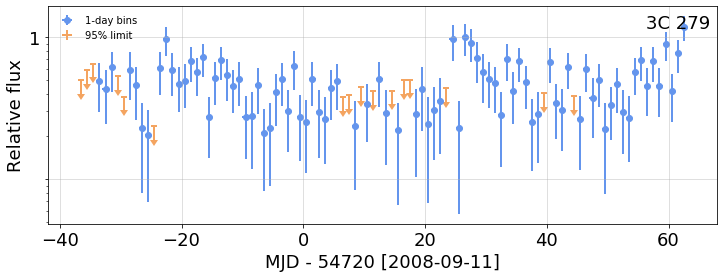

In [ ]:
lc.plot( tzero=54720, fmt='o', xlim=(0,50), log=True, ms=8, error_size=3);

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_exposure.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Tue May 18 16:25:40 PDT 2021
